In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import pandas as pd
import json
import xml.etree.ElementTree as ET

# Namespace for ArXiv's Atom-based XML format.
ARXIV_NAMESPACE = '{http://www.w3.org/2005/Atom}'


def extract_from_arxiv(search_query='cat:cs.AI', max_results=100, json_file_path='files/arxiv_dataset.json'):
    """
    Fetches papers from the ArXiv API based on a search query, saves them as JSON, 
    and returns a pandas DataFrame.

    Args:
        search_query (str): The search query for ArXiv (default is 'cat:cs.AI').
        max_results (int): The maximum number of results to retrieve (default is 100).
        json_file_path (str): File path where JSON data will be saved.

    Returns:
        pd.DataFrame: DataFrame containing the extracted paper information.
    """

    # Construct the URL for the API request.
    url = f'http://export.arxiv.org/api/query?search_query={search_query}&max_results={max_results}'

    # Send a GET request to the ArXiv API.
    response = requests.get(url)
    response.raise_for_status()

    # Parse the XML response.
    root = ET.fromstring(response.content)

    papers = []

    # Loop through each "entry" in the XML, representing a single paper.
    for entry in root.findall(f'{ARXIV_NAMESPACE}entry'):
        title_elem = entry.find(f'{ARXIV_NAMESPACE}title')
        title = title_elem.text.strip() if title_elem is not None and title_elem.text else ''

        summary_elem = entry.find(f'{ARXIV_NAMESPACE}summary')
        summary = summary_elem.text.strip(
        ) if summary_elem is not None and summary_elem.text else ''

        # Get the authors of the paper.
        author_elements = entry.findall(f'{ARXIV_NAMESPACE}author')
        authors = []
        for author in author_elements:
            name_elem = author.find(f'{ARXIV_NAMESPACE}name')
            if name_elem is not None and name_elem.text:
                authors.append(name_elem.text)

        # Get the paper's URL.
        id_elem = entry.find(f'{ARXIV_NAMESPACE}id')
        paper_url = id_elem.text if id_elem is not None and id_elem.text else ''
        arxiv_id = paper_url.split('/')[-1] if paper_url else ''

        # Check for the PDF link.
        pdf_link = next((link.attrib['href'] for link in entry.findall(f'{ARXIV_NAMESPACE}link')
                         if link.attrib.get('title') == 'pdf'), None)

        papers.append({
            'title': title,
            'summary': summary,
            'authors': authors,
            'arxiv_id': arxiv_id,
            'url': paper_url,
            'pdf_link': pdf_link
        })

    # Convert list into a pandas DataFrame.
    df = pd.DataFrame(papers)

    # Save the DataFrame to a JSON file.
    with open(json_file_path, 'w', encoding='utf-8') as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f'Data saved to {json_file_path} ...')

    return df

In [3]:
df = extract_from_arxiv(max_results=20)

Data saved to files/arxiv_dataset.json ...


In [4]:
import json
file_name = 'files/arxiv_dataset.json'
with open(file_name, 'r') as file:
    data = json.load(file)

print(data)

[{'title': 'A Deep Reinforcement Learning Approach for Ramp Metering Based on Traffic Video Data', 'summary': 'Ramp metering that uses traffic signals to regulate vehicle flows from the on-ramps has been widely implemented to improve vehicle mobility of the freeway. Previous studies generally update signal timings in real-time based on predefined traffic measures collected by point detectors, such as traffic volumes and occupancies. Comparing with point detectors, traffic cameras-which have been increasingly deployed on road networks-could cover larger areas and provide more detailed traffic information. In this work, we propose a deep reinforcement learning (DRL) method to explore the potential of traffic video data in improving the efficiency of ramp metering. The proposed method uses traffic video frames as inputs and learns the optimal control strategies directly from the high-dimensional visual inputs. A real-world case study demonstrates that, in comparison with a state-of-the-pr

In [5]:
import pandas as pd
df = pd.DataFrame(data)
df.sample(n=5)

,title,summary,authors,arxiv_id,url,pdf_link
0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,https://arxiv.org/pdf/2012.12104v1
15,Devil is in the Edges: Learning Semantic Bound...,We tackle the problem of semantic boundary pre...,"[David Acuna, Amlan Kar, Sanja Fidler]",1904.07934v2,http://arxiv.org/abs/1904.07934v2,https://arxiv.org/pdf/1904.07934v2
5,Skeleton-based Approaches based on Machine Vis...,"Recently, skeleton-based approaches have achie...","[Jie Li, Binglin Li, Min Gao]",2012.12447v1,http://arxiv.org/abs/2012.12447v1,https://arxiv.org/pdf/2012.12447v1
19,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,https://arxiv.org/pdf/1905.01984v1
7,Modelling Human Routines: Conceptualising Soci...,Our routines play an important role in a wide ...,"[Rijk Mercuur, Virginia Dignum, Catholijn M. J...",2012.11903v1,http://arxiv.org/abs/2012.11903v1,https://arxiv.org/pdf/2012.11903v1


In [6]:
import pandas as pd
import requests
import os


def download_pdfs(df, download_folder='files'):
    """
    Downloads PDFs from URLs listed in the DataFrame and saves them to a specified folder. 
    The file names are stored in a new column 'pdf_file_name' in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing a 'pdf_link' column with URLs to download.
        download_folder (str): Path to the folder where PDFs will be saved (default is 'files').

    Returns:
        pd.DataFrame: The original DataFrame with an additional 'pdf_file_name' column containing 
                      the paths of the downloaded PDF files or None if the download failed.
    """

    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    pdf_file_names = []

    # Loop through each row to download PDFs
    for index, row in df.iterrows():
        pdf_link = row['pdf_link']

        try:
            response = requests.get(pdf_link)
            response.raise_for_status()

            file_name = os.path.join(
                download_folder, pdf_link.split('/')[-1]) + '.pdf'
            pdf_file_names.append(file_name)

            # Save the downloaded PDF
            with open(file_name, 'wb') as f:
                f.write(response.content)

            print(f'PDF downloaded successfully and saved as {file_name}')

        except requests.exceptions.RequestException as e:
            print(f'Failed to download the PDF: {e}')
            pdf_file_names.append(None)

    df['pdf_file_name'] = pdf_file_names

    return df

In [7]:
df = download_pdfs(df)

PDF downloaded successfully and saved as files/2012.12104v1.pdf
PDF downloaded successfully and saved as files/2012.13026v1.pdf
PDF downloaded successfully and saved as files/2012.13293v1.pdf
PDF downloaded successfully and saved as files/2012.13315v1.pdf
PDF downloaded successfully and saved as files/2012.13391v2.pdf
PDF downloaded successfully and saved as files/2012.12447v1.pdf
PDF downloaded successfully and saved as files/2012.12634v1.pdf
PDF downloaded successfully and saved as files/2012.11903v1.pdf
PDF downloaded successfully and saved as files/2012.13569v1.pdf
PDF downloaded successfully and saved as files/2012.12718v1.pdf
PDF downloaded successfully and saved as files/2012.13666v1.pdf
PDF downloaded successfully and saved as files/2012.13677v1.pdf
PDF downloaded successfully and saved as files/2012.13779v1.pdf
PDF downloaded successfully and saved as files/2012.13872v1.pdf
PDF downloaded successfully and saved as files/2012.14005v1.pdf
PDF downloaded successfully and saved as

In [8]:
df

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,https://arxiv.org/pdf/2012.12104v1,files/2012.12104v1.pdf
1,Rethink AI-based Power Grid Control: Diving In...,"Recently, deep reinforcement learning (DRL)-ba...","[Xiren Zhou, Siqi Wang, Ruisheng Diao, Desong ...",2012.13026v1,http://arxiv.org/abs/2012.13026v1,https://arxiv.org/pdf/2012.13026v1,files/2012.13026v1.pdf
2,Fuzzy Commitments Offer Insufficient Protectio...,"In this work, we study the protection that fuz...","[Danny Keller, Margarita Osadchy, Orr Dunkelman]",2012.13293v1,http://arxiv.org/abs/2012.13293v1,https://arxiv.org/pdf/2012.13293v1,files/2012.13293v1.pdf
3,Generalization in portfolio-based algorithm se...,Portfolio-based algorithm selection has seen t...,"[Maria-Florina Balcan, Tuomas Sandholm, Ellen ...",2012.13315v1,http://arxiv.org/abs/2012.13315v1,https://arxiv.org/pdf/2012.13315v1,files/2012.13315v1.pdf
4,"I like fish, especially dolphins: Addressing C...",To quantify how well natural language understa...,"[Yixin Nie, Mary Williamson, Mohit Bansal, Dou...",2012.13391v2,http://arxiv.org/abs/2012.13391v2,https://arxiv.org/pdf/2012.13391v2,files/2012.13391v2.pdf
5,Skeleton-based Approaches based on Machine Vis...,"Recently, skeleton-based approaches have achie...","[Jie Li, Binglin Li, Min Gao]",2012.12447v1,http://arxiv.org/abs/2012.12447v1,https://arxiv.org/pdf/2012.12447v1,files/2012.12447v1.pdf
6,Overview of FPGA deep learning acceleration ba...,"In recent years, deep learning has become more...",[Simin Liu],2012.12634v1,http://arxiv.org/abs/2012.12634v1,https://arxiv.org/pdf/2012.12634v1,files/2012.12634v1.pdf
7,Modelling Human Routines: Conceptualising Soci...,Our routines play an important role in a wide ...,"[Rijk Mercuur, Virginia Dignum, Catholijn M. J...",2012.11903v1,http://arxiv.org/abs/2012.11903v1,https://arxiv.org/pdf/2012.11903v1,files/2012.11903v1.pdf
8,Dynamic-K Recommendation with Personalized Dec...,"In this paper, we investigate the recommendati...","[Yan Gao, Jiafeng Guo, Yanyan Lan, Huaming Liao]",2012.13569v1,http://arxiv.org/abs/2012.13569v1,https://arxiv.org/pdf/2012.13569v1,files/2012.13569v1.pdf
9,Compliance Generation for Privacy Documents un...,Most prominent research today addresses compli...,"[David Restrepo Amariles, Aurore Clément Trous...",2012.12718v1,http://arxiv.org/abs/2012.12718v1,https://arxiv.org/pdf/2012.12718v1,files/2012.12718v1.pdf


In [9]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


def load_and_chunk_pdf(pdf_file_name, chunk_size=512):
    """
    Loads a PDF file and splits its content into chunks of a specified size.

    Args:
        file (str): Path to the PDF file to be loaded.
        chunk_size (int): The maximum size of each chunk in characters (default is 512).

    Returns:
        List[Document]: A list of document chunks.
    """

    print(f'Loading and splitting into chunks: {pdf_file_name}')

    # Load the content of the PDF
    loader = PyPDFLoader(pdf_file_name)
    data = loader.load()

    # Split the content into chunks with slight overlap to preserve context
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=64)
    chunks = text_splitter.split_documents(data)

    return chunks

In [10]:
def expand_df(df):
    """
    Expands each row in the DataFrame by splitting PDF documents into chunks.

    Args:
        df (pd.DataFrame): DataFrame containing 'pdf_file_name', 'arxiv_id', 'title', 'summary', 
                           'authors', and 'url' columns.

    Returns:
        pd.DataFrame: A new DataFrame where each row represents a chunk of the original document, 
                      with additional metadata such as chunk identifiers and relationships to 
                      adjacent chunks.
    """

    expanded_rows = []  # List to store expanded rows with chunk information

    # Loop through each row in the DataFrame
    for idx, row in df.iterrows():
        try:
            chunks = load_and_chunk_pdf(row['pdf_file_name'])
        except Exception as e:
            print(f"Error processing file {row['pdf_file_name']}: {e}")
            continue

        # Loop over the chunks and construct a new DataFrame row for each
        for i, chunk in enumerate(chunks):
            prechunk_id = i-1 if i > 0 else ''  # Preceding chunk ID
            # Following chunk ID
            postchunk_id = i+1 if i < len(chunks) - 1 else ''

            expanded_rows.append({
                'id': f"{row['arxiv_id']}#{i}",  # Unique chunk identifier
                'title': row['title'],
                'summary': row['summary'],
                'authors': row['authors'],
                'arxiv_id': row['arxiv_id'],
                'url': row['url'],
                'chunk': chunk.page_content,  # Text content of the chunk
                # Previous chunk ID
                'prechunk_id': '' if i == 0 else f"{row['arxiv_id']}#{prechunk_id}",
                # Next chunk ID
                'postchunk_id': '' if i == len(chunks) - 1 else f"{row['arxiv_id']}#{postchunk_id}"
            })

    # Return a new expanded DataFrame
    return pd.DataFrame(expanded_rows)

In [11]:
expanded_df = expand_df(df)

Loading and splitting into chunks: files/2012.12104v1.pdf
Loading and splitting into chunks: files/2012.13026v1.pdf
Loading and splitting into chunks: files/2012.13293v1.pdf
Loading and splitting into chunks: files/2012.13315v1.pdf
Loading and splitting into chunks: files/2012.13391v2.pdf
Loading and splitting into chunks: files/2012.12447v1.pdf
Loading and splitting into chunks: files/2012.12634v1.pdf
Loading and splitting into chunks: files/2012.11903v1.pdf
Loading and splitting into chunks: files/2012.13569v1.pdf
Loading and splitting into chunks: files/2012.12718v1.pdf
Loading and splitting into chunks: files/2012.13666v1.pdf
Loading and splitting into chunks: files/2012.13677v1.pdf
Loading and splitting into chunks: files/2012.13779v1.pdf
Loading and splitting into chunks: files/2012.13872v1.pdf
Loading and splitting into chunks: files/2012.14005v1.pdf
Loading and splitting into chunks: files/1904.07934v2.pdf
Loading and splitting into chunks: files/1904.08010v1.pdf
Loading and sp

In [12]:
expanded_df

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,2012.12104v1#0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,1 \nA Deep Reinforcement Learning Approach for...,,2012.12104v1#1
1,2012.12104v1#1,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,Abstract \nRamp metering that uses traffic sig...,2012.12104v1#0,2012.12104v1#2
2,2012.12104v1#2,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,and provide more detailed traffic information....,2012.12104v1#1,2012.12104v1#3
3,2012.12104v1#3,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,method results in 1) lower travel times in the...,2012.12104v1#2,2012.12104v1#4
4,2012.12104v1#4,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,2 \nIntroduction \nRamp metering uses traffic ...,2012.12104v1#3,2012.12104v1#5
...,...,...,...,...,...,...,...,...,...
2195,1905.01984v1#123,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,Topic aware neural response generation . In Th...,1905.01984v1#122,1905.01984v1#124
2196,1905.01984v1#124,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,Personalized response generation via domain ad...,1905.01984v1#123,1905.01984v1#125
2197,1905.01984v1#125,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,generative adversarial nets with policy gradie...,1905.01984v1#124,1905.01984v1#126
2198,1905.01984v1#126,AI-Powered Text Generation for Harmonious Huma...,"In the last two decades, the landscape of text...","[Qiuyun Zhang, Bin Guo, Hao Wang, Yunji Liang,...",1905.01984v1,http://arxiv.org/abs/1905.01984v1,pets too? arXiv preprint arXiv:1801.07243. \n...,1905.01984v1#125,1905.01984v1#127


In [13]:
from dotenv import load_dotenv, find_dotenv

# Load the API keys from .env
load_dotenv(find_dotenv(), override=True)

True

In [14]:
import os
from getpass import getpass

from semantic_router.encoders import OpenAIEncoder

# Check if 'OPENAI_API_KEY' is set; prompt if not
os.environ['OPENAI_API_KEY'] = os.getenv(
    'OPENAI_API_KEY') or getpass('OpenAI API key: ')

# Initialize the OpenAIEncoder with a specific model
encoder = OpenAIEncoder(name='text-embedding-3-small')

In [15]:
encoder(['hello hallo hola salut'])

[[0.018540984019637108,
  -0.026004204526543617,
  0.01024363748729229,
  -0.031960148364305496,
  -0.004145014565438032,
  -0.04852557182312012,
  -0.016375185921788216,
  0.043345220386981964,
  -0.031521134078502655,
  -0.01843854784965515,
  0.00518035376444459,
  -0.08083692938089371,
  0.005348641891032457,
  -0.012482604011893272,
  -0.011004593223333359,
  0.09599751234054565,
  -0.0386916808784008,
  0.025477388873696327,
  -0.0030365067068487406,
  0.04275986924767494,
  0.04524761065840721,
  0.011099712923169136,
  -0.039569709450006485,
  0.04000872001051903,
  0.03169674053788185,
  0.029165098443627357,
  0.02499447576701641,
  0.015599596314132214,
  0.014150853268802166,
  -0.013755741529166698,
  0.04533541202545166,
  -0.053501054644584656,
  -0.014963027089834213,
  0.025053009390830994,
  -0.0031499185133725405,
  -0.020838486030697823,
  -0.024365223944187164,
  0.0093070762231946,
  0.007038842421025038,
  -0.01694590225815773,
  -0.001152409240603447,
  -0.03307

In [16]:
dims = len(encoder(['hello hallo hola salut'])[0])
dims

1536

In [17]:
from pinecone import Pinecone, ServerlessSpec

# Check if 'PINECONE_API_KEY' is set; prompt if not
api_key = os.getenv('PINECONE_API_KEY') or getpass('Pinecone API key: ')

# Initialize the Pinecone client
pc = Pinecone(api_key=api_key)

# Define the serverless specification for Pinecone (AWS region 'us-east-1')
spec = ServerlessSpec(
    cloud='aws',
    region='us-east-1'
)

In [18]:
import time

# Define the name of the index
index_name = 'langgraph-research-agent'

# Check if the index exists; create it if it doesn't
if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=dims,  # Embedding dimension (1536)
        metric='cosine',
        spec=spec  # Cloud provider and region specification
    )

    # Wait until the index is fully initialized
    while True:
        description = pc.describe_index(index_name)
        if description and description.status and description.status.get('ready'):
            break
        time.sleep(1)

# Connect to the index
index = pc.Index(index_name)

# Add a short delay before checking the stats
time.sleep(1)

# View the index statistics
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '188',
                                    'content-type': 'application/json',
                                    'date': 'Mon, 09 Feb 2026 11:40:46 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '67',
                                    'x-pinecone-request-latency-ms': '66',
                                    'x-pinecone-response-duration-ms': '68'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'__default__': {'vector_count': 2200}},
 'storageFullness': 0.0,
 'total_vector_count': 2200,
 'vector_type': 'dense'}

In [19]:
expanded_df.iloc[:5]

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,2012.12104v1#0,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,1 \nA Deep Reinforcement Learning Approach for...,,2012.12104v1#1
1,2012.12104v1#1,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,Abstract \nRamp metering that uses traffic sig...,2012.12104v1#0,2012.12104v1#2
2,2012.12104v1#2,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,and provide more detailed traffic information....,2012.12104v1#1,2012.12104v1#3
3,2012.12104v1#3,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,method results in 1) lower travel times in the...,2012.12104v1#2,2012.12104v1#4
4,2012.12104v1#4,A Deep Reinforcement Learning Approach for Ram...,Ramp metering that uses traffic signals to reg...,"[Bing Liu, Yu Tang, Yuxiong Ji, Yu Shen, Yuchu...",2012.12104v1,http://arxiv.org/abs/2012.12104v1,2 \nIntroduction \nRamp metering uses traffic ...,2012.12104v1#3,2012.12104v1#5


In [20]:
from tqdm.auto import tqdm

data = expanded_df
batch_size = 64  # Set batch size

# Loop through the data in batches, using tqdm for a progress bar
for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)  # Define batch endpoint
    batch = data[i:i_end].to_dict(orient='records')  # Slice data into a batch

    # Extract metadata for each chunk in the batch
    metadata = [{
        'arxiv_id': r['arxiv_id'],
        'title': r['title'],
        'chunk': r['chunk'],
    } for r in batch]

    # Generate unique IDs for each chunk
    ids = [r['id'] for r in batch]

    # Extract the chunk content
    chunks = [r['chunk'] for r in batch]

    # Convert chunks into embeddings
    embeds = encoder(chunks)

    # Upload embeddings, IDs, and metadata to Pinecone
    index.upsert(vectors=list(zip(ids, embeds, metadata)))

  0%|          | 0/35 [00:00<?, ?it/s]

2026-02-09 06:41:00 - urllib3.connectionpool - WARNING - connectionpool.py:868 - urlopen() - Retrying (JitterRetry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectionResetError(54, 'Connection reset by peer')': /vectors/upsert
2026-02-09 06:41:01 - urllib3.connectionpool - WARNING - connectionpool.py:868 - urlopen() - Retrying (JitterRetry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectionResetError(54, 'Connection reset by peer')': /vectors/upsert
2026-02-09 06:41:19 - urllib3.connectionpool - WARNING - connectionpool.py:868 - urlopen() - Retrying (JitterRetry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectionResetError(54, 'Connection reset by peer')': /vectors/upsert
2026-02-09 06:41:20 - urllib3.connectionpool - WARNING - connectionpool.py:868 - urlopen() - Retrying (JitterRetry(total=3, connect=None, read=None, redirect=None, statu

In [21]:
# Display the index statistics.
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '188',
                                    'content-type': 'application/json',
                                    'date': 'Mon, 09 Feb 2026 11:41:32 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '38',
                                    'x-pinecone-request-latency-ms': '37',
                                    'x-pinecone-response-duration-ms': '39'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'__default__': {'vector_count': 2200}},
 'storageFullness': 0.0,
 'total_vector_count': 2200,
 'vector_type': 'dense'}

In [22]:
import requests
# Specify the arXiv ID for the paper
arxiv_id = '1706.03762'

# Make a GET request to retrieve the page for the specified paper
res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

# Access the content of the response as a string (HTML)
res.text

'<!DOCTYPE html>\n<html lang="en">\n\n<head>  <title>[1706.03762] Attention Is All You Need</title>\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link rel="apple-touch-icon" sizes="180x180" href="/static/browse/0.3.4/images/icons/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/static/browse/0.3.4/images/icons/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/static/browse/0.3.4/images/icons/favicon-16x16.png">\n  <link rel="manifest" href="/static/browse/0.3.4/images/icons/site.webmanifest">\n  <link rel="mask-icon" href="/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#da532c">\n  <meta name="theme-color" content="#ffffff">\n  <link rel="stylesheet" type="text/css" media="screen" href="/static/browse/0.3.4/css/arXiv.css?v=20241206" />\n  <link rel="stylesheet" type="text/css" media="print" href="/static/browse/0.3.4/css/a

In [23]:
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# Search for the abstract in the HTML response text
re_match = abstract_pattern.search(res.text)

# Check if the abstract was found and print it; otherwise, display an error message
if re_match:
    print(re_match.group(1))
else:
    print('Abstract not found.')

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

In [24]:
from langchain_core.tools import tool
import requests
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)


@tool('fetch_arxiv')
def fetch_arxiv(arxiv_id: str) -> str:
    '''Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.

    Returns:
        str: The extracted abstract text from the ArXiv paper.
    '''

    res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

    re_match = abstract_pattern.search(res.text)

    return re_match.group(1) if re_match else 'Abstract not found.'

In [25]:
# Defining the ArXiv paper ID and invoking the tool with that ID.
arxiv_id = '1706.03762'
output = fetch_arxiv.invoke(input={'arxiv_id': arxiv_id})
print(output)

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

In [26]:
from dotenv import load_dotenv, find_dotenv

# Load the API keys from .env
load_dotenv(find_dotenv(), override=True)

True

In [27]:
from serpapi import GoogleSearch
import os
from getpass import getpass

# Set up the SerpAPI request parameters, including the API key.
serpapi_params = {
    'engine': 'google',
    # Get the API key securely.
    'api_key': os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')
}

# Perform a Google search for the keyword "water" and limit the results to 5.
search = GoogleSearch({
    **serpapi_params,
    'q': 'water',
    'num': 5
})


# Extract the main search results from the API response.
results = search.get_dict().get('organic_results', [])

# Format the search results for readability.
formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
)

In [28]:
print(formatted_results)

Water
Water is an inorganic compound with the chemical formula H 2 O. It is a transparent, tasteless, odorless, [c] and nearly colorless chemical substance
https://en.wikipedia.org/wiki/Water
---
Water | H2O | CID 962 - PubChem - NIH
Water appears as a clear, nontoxic liquid composed of hydrogen and oxygen, essential for life and the most widely used solvent.
https://pubchem.ncbi.nlm.nih.gov/compound/Water
---
Water Utilities Home
Access your account, contact customer service, residential rates, water quality developer information, find your provider.
https://discover.pbc.gov/waterutilities/Pages/default.aspx


In [29]:
from serpapi import GoogleSearch

# Define the 'web_search' tool using the '@tool' decorator.


@tool('web_search')
def web_search(query: str) -> str:
    '''Finds general knowledge information using a Google search.

    Args:
        query (str): The search query string.

    Returns:
        str: A formatted string of the top search results, including title, snippet, and link.
    '''

    search = GoogleSearch({
        **serpapi_params,
        'q': query,
        'num': 5
    })

    results = search.get_dict().get('organic_results', [])
    formatted_results = '\n---\n'.join(
        ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
    )

    # Return the formatted results or a 'No results found.' message if no results exist.
    return formatted_results if results else 'No results found.'

In [30]:
# Invoke the 'web_search' tool with the query 'water on mars'
output = web_search.invoke(input={'query': 'water on mars'})
print(output)

Water on Mars
Mars contains water, though mostly as subsurface permafrost. Surface water is readily visible at some places, such as the ice-filled Korolev Crater, near the ...
https://en.wikipedia.org/wiki/Water_on_Mars
---
NASA Confirms Evidence That Liquid Water Flows ...
New findings from NASA's Mars Reconnaissance Orbiter (MRO) provide the strongest evidence yet that liquid water flows intermittently on present-day Mars.
https://www.nasa.gov/news-release/nasa-confirms-evidence-that-liquid-water-flows-on-todays-mars/
---
Mars water: Liquid water reservoirs found under Martian crust
Scientists have discovered a reservoir of liquid water on Mars - deep in the rocky outer crust of the planet.
https://www.bbc.com/news/articles/czxl849j77ko


In [31]:
def format_rag_contexts(matches: list) -> str:
    '''Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.

    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.
    '''
    formatted_results = []

    # Loop through each match and extract its metadata.
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
        )
        # Append each formatted string to the results list.
        formatted_results.append(text)

    # Join all the individual formatted strings into one large string.
    return '\n---\n'.join(formatted_results)

In [32]:
from langchain_core.tools import tool


@tool
def rag_search_filter(query: str, arxiv_id: str) -> str:
    '''Finds information from the ArXiv database using a natural language query and a specific ArXiv ID.

    Args:
        query (str): The search query in natural language.
        arxiv_id (str): The ArXiv ID of the specific paper to filter by.

    Returns:
        str: A formatted string of relevant document contexts.
    '''

    # Encode the query into a vector representation.
    xq = encoder([query])

    # Perform a search on the Pinecone index, filtering by ArXiv ID.
    xc = index.query(vector=xq[0], top_k=6, include_metadata=True,
                     filter={'arxiv_id': arxiv_id})

    # Format and return the search results.
    return format_rag_contexts(xc.matches)  # type: ignore[attr-defined]

In [33]:
@tool('rag_search')
def rag_search(query: str) -> str:
    '''Finds specialist information on AI using a natural language query.

    Args:
        query (str): The search query in natural language.

    Returns:
        str: A formatted string of relevant document contexts.
    '''

    # Encode the query into a vector representation.
    xq = encoder([query])

    # Perform a broader search without filtering by ArXiv ID.
    xc = index.query(vector=xq[0], top_k=5, include_metadata=True)

    # Format and return the search results.
    return format_rag_contexts(xc.matches)  # type: ignore[attr-defined]

In [34]:
from langchain_core.tools import tool
from typing import Union

# Define the 'final_answer' tool to compile the research report.


@tool
def final_answer(
    introduction: str,
    research_steps: Union[str, list],
    main_body: str,
    conclusion: str,
    sources: Union[str, list]
) -> str:
    '''Returns a natural language response in the form of a research report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.
        research_steps (Union[str, list]): Bullet points or text explaining the steps taken for research.
        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.
        conclusion (str): A short paragraph summarizing the findings.
        sources (Union[str, list]): A list or text providing the sources referenced during the research.

    Returns:
        str: A formatted research report string.
    '''

    # Format research steps if given as a list.
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])

    # Format sources if given as a list.
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])

    # Construct and return the final research report.
    return f'{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\n \
    Conclusion:\n{conclusion}\n\nSources:\n{sources}'

In [35]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define the system prompt guiding the AI's decision-making process.
system_prompt = (
    '''You are the oracle, the great AI decision-maker.
    Given the user's query, you must decide what to do with it based on the
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, do NOT use that same tool with the same query again. Also, do NOT use
    any tool more than twice (i.e., if the tool appears in the scratchpad twice, do
    not use it again).

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have collected plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.'''
)


# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  # Define the AI's role and rules.

    # Insert past chat messages to maintain context.
    MessagesPlaceholder(variable_name='chat_history'),

    # Insert user's input dynamically.
    ('user', '{input}'),

    # Include the assistant's scratchpad to track tool usage and intermediate steps.
    ('assistant', 'scratchpad: {scratchpad}'),
])

In [36]:
# from langchain_core.messages import ToolCall, ToolMessage
from langchain_core.agents import AgentAction
from langchain_openai import ChatOpenAI
import os

# Initialize the OpenAI language model with specific settings.
llm = ChatOpenAI(
    model='gpt-4o',
    # openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.


def create_scratchpad(intermediate_steps: list[AgentAction]) -> str:
    research_steps = []

    # Loop over each step and process tool calls with actual outputs.
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
            )

    # Join the research steps into a readable log.
    return '\n---\n'.join(research_steps)


# Define the oracle's decision-making pipeline.
oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)

In [37]:
# input = 'Tell me something interesting about dynamic backtracking AI and LLMs'
# input = 'Who won the Super Bowl 2025?'
input = 'What is the ArXiv paper with the ID 2012.12104v1 all about?'
# Create the inputs dictionary, containing the user's query and initial empty chat history and intermediate steps.
inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}

# Invoke the oracle with the inputs, processing the query and returning a response.
out = oracle.invoke(inputs)

# Display the oracle's response.
print(out)

content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 613, 'total_tokens': 636, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ad98c18a04', 'id': 'chatcmpl-D7JvxDXcezUWjsdGodm5jENbSmhVw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019c4234-f48d-7771-9e0f-a114eff3c72f-0' tool_calls=[{'name': 'fetch_arxiv', 'args': {'arxiv_id': '2012.12104v1'}, 'id': 'call_YTnGPW9s0ifv49Mg1J2JibpR', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 613, 'output_tokens': 23, 'total_tokens': 636, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [38]:
out.tool_calls[0]['name']

'fetch_arxiv'

In [39]:
out.tool_calls[0]['args']

{'arxiv_id': '2012.12104v1'}

In [40]:
# run_oracle(): main function that executes the oracle and processes its output to extract the relevant tool and its arguments.
# We'll use this information to update the state for future steps.
def run_oracle(state: dict) -> dict:
    '''Runs the oracle and processes the output to extract tool information.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool action.
    '''

    print('run_oracle')
    print(f'intermediate_steps: {state["intermediate_steps"]}')

    # Invoke the oracle with the current state.
    out = oracle.invoke(state)

    # Extract the tool name and its arguments from the oracle's response.
    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    # Create an AgentAction object, which records the tool used and the input provided.
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  # To be determined later after the tool runs.
    )

    # Return a new state with updated 'intermediate_steps'.
    return {
        'intermediate_steps': [action_out]
    }


# The router() function determines the next tool to use based on the current state.
def router(state: dict) -> str:
    '''Determines the next tool to use based on the current state.

    Args:
        state (dict): The current state containing 'intermediate_steps'.

    Returns:
        str: The name of the tool to use next.
    '''

    if isinstance(state['intermediate_steps'], list):
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    'rag_search_filter': rag_search_filter,
    'rag_search': rag_search,
    'fetch_arxiv': fetch_arxiv,
    'web_search': web_search,
    'final_answer': final_answer
}

# The run_tool() function executes the appropriate tool based on the current state.


def run_tool(state: dict) -> dict:
    '''Executes the appropriate tool based on the current state.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool's result.
    '''

    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input

    print(f'{tool_name}.invoke(input={tool_args})')

    out = tool_str_to_func[tool_name].invoke(input=tool_args)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    return {'intermediate_steps': [action_out]}

In [41]:
from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    '''Represents the state of an agent.'''

    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[AgentAction], operator.add]

In [42]:
from langgraph.graph import StateGraph, END

# Initialize the state graph with AgentState to manage the workflow.
graph = StateGraph(AgentState)

graph.add_node('oracle', run_oracle)
graph.add_node('rag_search_filter', run_tool)
graph.add_node('rag_search', run_tool)
graph.add_node('fetch_arxiv', run_tool)
graph.add_node('web_search', run_tool)
graph.add_node('final_answer', run_tool)

# Set the entry point to 'oracle'.
graph.set_entry_point('oracle')

# Add conditional edges to determine the next step using the router function.
graph.add_conditional_edges(source='oracle', path=router)

# Add edges from each tool back to 'oracle', except 'final_answer', which leads to 'END'.
for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'oracle')

graph.add_edge('final_answer', END)

# Compile the graph to make it executable.
runnable = graph.compile()

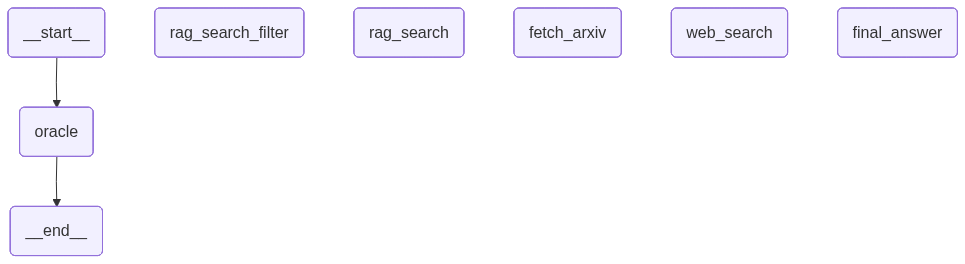

In [43]:
from IPython.display import Image, display

# Display the graph as a PNG using Mermaid rendering.
display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})

In [ ]:
def build_report(output: dict) -> str:
    '''Builds a formatted report based on the oracle's output.

    Args:
        output (dict): A dictionary containing the various sections of the report (graph's output).

    Returns:
        str: A formatted string containing the full research report.
    '''
    research_steps = output['research_steps']
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])

    sources = output['sources']
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])

    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}
        
        RESEARCH STEPS
        --------------
        {research_steps}
        
        REPORT
        ------
        {output['main_body']}
        
        CONCLUSION
        ----------
        {output['conclusion']}
        
        SOURCES
        -------
        {sources}
    """

In [ ]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})

In [ ]:
output['intermediate_steps'][-1].tool_input

In [ ]:
output = runnable.invoke({
    'input': 'tell me about FIFA World Cup 26',
    'chat_history': []
})

In [ ]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)

In [ ]:
output = runnable.invoke({
    'input': 'Create a summary about this AxXiv paper with the ID 2409.17990',
    'chat_history': []
})

In [ ]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)

In [ ]:
output = runnable.invoke({
    'input': 'Create a summary about the future of LLM Agents.',
    'chat_history': []
})

report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)